In [83]:
# References used :
# https://github.com/quinngroup/dr1dl-pyspark/wiki/Rank-1-Dictionary-Learning-Pseudocode
# https://github.com/Deepayan137/K-svd/blob/master/main_vamsi_2.py
# https://github.com/Rehan-Ahmad/Dictionary-Learning-Algorithms/blob/master/Dictionary_learning_v2.py
# ----------------------------------------Packages Used ------------------------------------------------------#

import cv2
import os
import copy
import random
import matplotlib.pyplot as plt
import numpy as np
from operator import mul, sub
from functools import reduce
import pandas as pd
import math
from math import floor, sqrt, log10
from scipy.sparse.linalg import svds
from sklearn import preprocessing
from sklearn.preprocessing import normalize
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
from sklearn.linear_model import orthogonal_mp_gram
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.linear_model import OrthogonalMatchingPursuit as omp
import timeit
import sys

In [84]:
# def dict_initiate(drows,dcols):
#     D = np.random.rand(drows,dcols)
#     D = preprocessing.normalize(D,norm='l2',axis=0) 
#     print( 'Shape of dictionary : ' , str(D.shape) + '\n')
#     return D

def dict_initiate(train_noisy_patches, dict_size,option):
    if option == "random_point":
        dict_init = np.random.randn(train_noisy_patches.shape[0],dict_size)
        # dictionary intialization

        # dictionary normalization
        
    elif option == "random_data":
        indexes = np.random.random_integers(0, train_noisy_patches.shape[1]-1, dict_size)   # indexes of patches for dictionary elements
        dict_init = np.array(train_noisy_patches[:, indexes])  
        dict_init  = normalize(dict_init)
        pass
    elif option =="glorot":
        dict_init = np.random.randn(train_noisy_patches.shape[0],dict_size)
        glorot_cons = math.sqrt(2/(dict_init.shape[0]+dict_init.shape[1]))
        dict_init = dict_init*glorot_cons
        pass

    print( 'Shape of dictionary : ' , str(dict_init.shape) + '\n')

    return dict_init

In [85]:
def call_for_dict_update(sparse_temp,D_temp,data,atom_id):
    sparse_temp[atom_id,:] = 0
    matrix_e_k = data[:, indices] - D_temp.dot(sparse_temp)
    u, s, v = svds(np.atleast_2d(matrix_e_k), 1)
    D_temp[:, atom_id] = u[:, 0]
    return D_temp,sparse_temp

def dict_update(D, data, matrix_sparse, atom_id):
    indices = np.where(matrix_sparse[atom_id, :] != 0)[0]
    D_temp = copy.deepcopy(D)
    sparse_temp = matrix_sparse[:,indices]

    if len(indices) > 1:
        D_temp,sparse_temp = call_for_dict_update(sparse_temp,D_temp,data,atom_id)
    return D_temp

In [86]:
def recons_error(X,D,Z):
    error  = X.T - (D.dot(Z.T))
    return np.linalg.norm(error)
    

In [102]:
def sparse_update(D,dataset_main,sparsity):
    
    omp_obj = omp(n_nonzero_coefs=sparsity)
    omp_obj  = omp_obj.fit(D, dataset_main.T)
    matrix_sparse = copy.deepcopy(omp_obj.coef_)
    return matrix_sparse

In [88]:
def k_svd(dataset_main, dict_size, sparsity,option):

    dict_init = dict_initiate(dataset_main.T, dict_size,option)
    D = copy.deepcopy(dict_init)
    matrix_sparse = np.zeros((D.T.dot(dataset_main.T)).shape)         # initializing spare matrix
    num_iter = ksvd_iter
    print ('\nK-SVD, with residual way.')
    # 
    print ('-------------------------------')
    
    for k in range(num_iter):

        print ("Stage " , str(k+1) , "/" , str(num_iter) , "...")

        matrix_sparse = sparse_update(D,dataset_main,sparsity)
        count = 1

        dict_elem_order = np.random.permutation(D.shape[1])

        for j in dict_elem_order:
            D_temp = dict_update(D, dataset_main.T, matrix_sparse, j)
            if D_temp.shape[1] == 1 or D_temp.shape[1]==0:
                continue
            else:
                D = copy.deepcopy(D_temp)
                
            count += 1
        print("Reconstruction Error in  ",(k+1)," Iteration : ",recons_error(dataset_main,D,matrix_sparse))
        print ('\r- Dictionary updating complete.\n')

    return D, matrix_sparse

In [89]:
def k_svd_transfer(dataset_main, dict_size, sparsity,dict_learned,option):

    dict_init = copy.deepcopy(dict_learned)

    D = copy.deepcopy(dict_init)

    matrix_sparse = np.zeros((D.T.dot(dataset_main.T)).shape)         # initializing spare matrix
    num_iter = ksvd_iter
    print ('\nK-SVD, with residual criterion.')
    print ('-------------------------------')
    
    for k in range(num_iter):

        print ("Stage " , str(k+1) , "/" , str(num_iter) , "...")

#         matrix_sparse = omp(D, dataset_main, sparsity)
        matrix_sparse = sparse_update(D,dataset_main,sparsity)
        
        count = 1

        dict_elem_order = np.random.permutation(D.shape[1])

        for j in dict_elem_order:
            D_temp = dict_update(D, dataset_main.T, matrix_sparse, j)
            if D_temp.shape[1] == 1 or D_temp.shape[1]==0:
                continue
            else:
                D = copy.deepcopy(D_temp)
                
            count += 1
        print("Reconstruction Error in  ",(k+1)," Iteration : ",recons_error(dataset_main,D,matrix_sparse))
        print ('\r- Dictionary updating complete.\n')

    return D, matrix_sparse

In [90]:
def check_file_image(file_path):
    '''Checking file to be image with extension .pgm
    Arguments : 
    file : filename to be check for image or not
    Return true if file is image and false if not image.
    
    '''
    if cv2.imread(file_path) is None or cv2.imread(file_path).size == 0: 
        return False
    return True

In [91]:
def data_read_yale_1(directory_loc,size):
    '''Create dataset for particular directory 
    Parameters :
    directory_loc : location where all classes data are present
    
    '''
    list_file  = os.listdir(directory_loc)
    dataset = [[] for i in list_file]
    label = [[] for i in list_file]
    for i in range(len(list_file)):
        print("Counter for directory: ",i)
        images  = os.listdir(directory_loc + "/"+list_file[i])
        for j in range(len(images)):
#             if j%250==0:
#                 print("Counter : ",j)
            if check_file_image(str(directory_loc+"/"+list_file[i]+"/"+images[j])):
                img = cv2.imread(str(directory_loc+"/"+list_file[i]+"/"+images[j]),0)
                img = cv2.resize(img,(size,size))
                img = img.ravel()
                dataset[i].append(img)
                label[i].append(i)
                
    return dataset,label

In [92]:
def data_split(data,label,train_test_split):
    '''Make random shuffle of data and split into train and test set
    Parameters are as:
    data: whole dataset to split
    label : whole labels corresponding to each data points
    train_test_split : ration of split i.e, for ex: 10/7, if want to split 7:3
    '''
    split = int(len(data)/train_test_split)
    data_sample=[]
    for i in range(len(data)):
        temp=[]
        temp.append(data[i])
        temp.append(label[i])
        data_sample.append(temp)
    data_sample = random.sample(data_sample,len(data_sample))
    data=[]
    label=[]
    for i in range(len(data_sample)):
        data.append(data_sample[i][0])
        label.append(data_sample[i][1])
    return np.array(data[:split]),np.array(label[:split]),np.array(data[split:]),np.array(label[split:]),np.array(data),np.array(label)

In [93]:
def model_drive(data,label):
    '''Fuction to return the model fitted on data and label given 
    Parameters : 
    data : train data used for fitting the model 
    label : suprvised label for fitting the model 
    '''
    gnb = GaussianNB()
    gnb.fit(data,label)
    return gnb
    

In [94]:
def predict_test_dict_model(gnb,D,test_data,train_data,sparsity):
    
    omp_obj = omp(n_nonzero_coefs=sparsity)
    omp_test  = omp_obj.fit(D, test_data.T)
    test_data = copy.deepcopy(omp_test.coef_)
    return test_data
        
        

In [95]:
# def predict_test_dict_reconstruction(D,test_data):
#     predict_label = []
#     for i in test_data:
#         reconstruction_error = []
#         for j in D:
            
#             sparse = i.dot(j)
#             reconstruction_error.append(sparse.dot(j.T) - i)
#         predict_label.append(np.argmin(reconstruction_error))
#     return predict_label

# Dataset Visualization

In [97]:
def tsne_plot(dataset_main,label_main,title,classes):
    #TSNE Plot for glass dataset
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(dataset_main)

    df_subset = pd.DataFrame()
    df_subset['X'] = tsne_results[:,0]
    df_subset['y']=label_main
    df_subset['Y'] = tsne_results[:,1]
    plt.figure(figsize=(6,4))
    plt.title(title)
    sns.scatterplot(
        x="X", y="Y",
        hue="y",
        palette=sns.color_palette("hls", classes),
        data=df_subset,
        legend="full",
        alpha=1.0
    )

In [98]:
def accuracy(predict_label,true_label):
    count = 0
    for i in range(len(predict_label)):
        if int(predict_label[i]) == int(true_label[i]):
            count = count +1
    return count/len(predict_label)

In [99]:
dataset,label = data_read_yale_1("./Dataset/Question_1",20)
dataset_main = []
for i in dataset:
    dataset_main = dataset_main + i
label_main = []
for i in label:
    label_main = label_main + i
label_main = np.array(label_main)
dataset_main = np.array(dataset_main)
# Dictionary : 1024 * 1000
# Sparse matrix : 1000 * no of datapoints
train_data,train_label,test_data,test_label,data,label = data_split(dataset_main,label_main,1.5)

Counter for directory:  0
Counter for directory:  1
Counter for directory:  2
Counter for directory:  3
Counter for directory:  4


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1950 samples in 0.049s...
[t-SNE] Computed neighbors for 1950 samples in 3.868s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1950
[t-SNE] Computed conditional probabilities for sample 1950 / 1950
[t-SNE] Mean sigma: 177.863838
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.493469
[t-SNE] KL divergence after 300 iterations: 1.055183


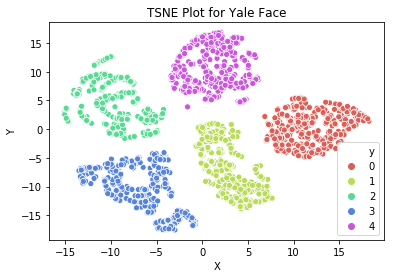

In [101]:
tsne_plot(train_data,train_label,"TSNE Plot for Yale Face",5)

In [103]:
num_dict=1000   
ksvd_iter = 10   
max_sparsity = 1
D,mat_sparse = k_svd(train_data,num_dict,max_sparsity,"random")

In [ ]:
# Training and Testing Accuracy using Model Methodology
gnb = model_drive(mat_sparse,train_label)
accuracy = gnb.score(mat_sparse,train_label)
print("Training Accuracy : ", accuracy)
test_data_sparse = predict_test_dict_model(gnb,D,test_data,train_data,max_sparsity)
print("Testing Accuracy : ", gnb.score(test_data_sparse,test_label))

# Visualization of Dictionary 

In [ ]:
for i in range(5):
    plt.imshow(D.T[i].reshape(20,20))
    print("Dictionary Visualization : ",(i+1))
    plt.show()
    

# Transfer Learning 

In [ ]:
dataset,label = data_read_yale_1("./Dataset/Question_3",20)
dataset_main = []
for i in dataset:
    dataset_main = dataset_main + i
label_main = []
for i in label:
    label_main = label_main + i
label_main = np.array(label_main)
dataset_main = np.array(dataset_main)
# Dictionary : 1024 * 1000
# Sparse matrix : 1000 * no of datapoints
train_data,train_label,test_data,test_label,data,label = data_split(dataset_main,label_main,1.5)

In [ ]:
num_dict=1000   
ksvd_iter = 10   
max_sparsity = 1
D_transfer = copy.deepcopy(D)
D,mat_sparse = k_svd_transfer(train_data,num_dict,max_sparsity,D_transfer,"random")

In [ ]:
# Training and Testing Accuracy using Model Methodology
gnb = model_drive(mat_sparse,train_label)
accuracy = gnb.score(mat_sparse,train_label)
print("Training Accuracy : ", accuracy)
test_data_sparse = predict_test_dict_model(gnb,D,test_data,train_data,max_sparsity)
print("Testing Accuracy : ", gnb.score(test_data_sparse,test_label))